In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from scipy.stats import poisson
import xgboost as xgb
import torch



# CONFIG 
DATA_PATH = r"D:\Predictor\khel_metrics\science_exhibition\data2_filled_safe.csv"
SPLIT_DATE = pd.to_datetime("2025-11-07")
INITIAL_ELO = 1500
N_SIM = 5000
MAX_GOALS = 10
CV_FOLDS = 5
SEED = 42
np.random.seed(SEED)

#  LOAD DATA 
df = pd.read_csv(DATA_PATH)
df['match_date'] = pd.to_datetime(df['match_date'], errors='coerce')
df = df.sort_values('match_date').reset_index(drop=True)

#  Keep original team names 
df['home_team_name_orig'] = df['home_team']
df['away_team_name_orig'] = df['away_team']

#  Encode categorical features for modeling 
for col in ['home_team', 'away_team']:
    df[col] = df[col].astype('category').cat.codes

#  Feature Engineering 
df['match_id'] = np.arange(len(df))
if 'home_elo' not in df.columns or df['home_elo'].isnull().all():
    df['home_elo'] = INITIAL_ELO
    df['away_elo'] = INITIAL_ELO
df['match_num_home'] = df.groupby('home_team').cumcount() + 1
df['match_num_away'] = df.groupby('away_team').cumcount() + 1

#  Features 
feature_cols = df.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in feature_cols if c not in ['home_goals','away_goals']]

train_df = df[df['match_date'] < SPLIT_DATE].copy()
test_df = df[df['match_date'] >= SPLIT_DATE].copy()
y_train_home = train_df['home_goals']
y_train_away = train_df['away_goals']

#  Impute 
imp = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imp.fit_transform(train_df[feature_cols]), columns=feature_cols)
X_test = pd.DataFrame(imp.transform(test_df[feature_cols]), columns=feature_cols)

#  XGBoost Poisson parameters 
xgb_params = {
    "objective": "count:poisson",
    "learning_rate": 0.02,
    "max_depth": 4,
    "subsample": 0.85,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.2,
    "seed": SEED,
    "tree_method": "hist",
    "verbosity": 0
}

#  CV with XGBoost 
tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
oof_preds = np.zeros((len(train_df), 2))
oof_probs = np.zeros((len(train_df), 3))
oof_true_outcome = np.full(len(train_df), -1, dtype=int)
cv_metrics = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_home, y_val_home = y_train_home.iloc[train_idx], y_train_home.iloc[val_idx]
    y_tr_away, y_val_away = y_train_away.iloc[train_idx], y_train_away.iloc[val_idx]

    dtrain_home = xgb.DMatrix(X_tr, label=y_tr_home)
    dval_home = xgb.DMatrix(X_val, label=y_val_home)
    dtrain_away = xgb.DMatrix(X_tr, label=y_tr_away)
    dval_away = xgb.DMatrix(X_val, label=y_val_away)

    evals_home = [(dtrain_home, 'train'), (dval_home, 'eval')]
    evals_away = [(dtrain_away, 'train'), (dval_away, 'eval')]

    home_model = xgb.train(xgb_params, dtrain_home, num_boost_round=2000, evals=evals_home,
                           early_stopping_rounds=50, verbose_eval=False)
    away_model = xgb.train(xgb_params, dtrain_away, num_boost_round=2000, evals=evals_away,
                           early_stopping_rounds=50, verbose_eval=False)

    pred_val_home = home_model.predict(dval_home).clip(0.05, 10)
    pred_val_away = away_model.predict(dval_away).clip(0.05, 10)
    oof_preds[val_idx, 0] = pred_val_home
    oof_preds[val_idx, 1] = pred_val_away

    for i, idx in enumerate(val_idx):
        ph = poisson.pmf(np.arange(MAX_GOALS+1), pred_val_home[i])
        pa = poisson.pmf(np.arange(MAX_GOALS+1), pred_val_away[i])
        joint = np.outer(ph, pa)
        oof_probs[idx] = [np.tril(joint, -1).sum(), np.trace(joint), np.triu(joint, 1).sum()]

    h_goals = y_val_home.values
    a_goals = y_val_away.values
    oof_true_outcome[val_idx] = np.where(h_goals>a_goals,0,np.where(h_goals==a_goals,1,2))

    rmse_home = np.sqrt(np.mean((h_goals - pred_val_home)**2))
    rmse_away = np.sqrt(np.mean((a_goals - pred_val_away)**2))
    r2_home = r2_score(h_goals, pred_val_home)
    r2_away = r2_score(a_goals, pred_val_away)
    match_acc = np.mean(np.sign(h_goals - a_goals) == np.sign(pred_val_home - pred_val_away))
    cv_metrics.append(((rmse_home+rmse_away)/2,(r2_home+r2_away)/2,match_acc))
    print(f"Fold {fold} → RMSE: {(rmse_home+rmse_away)/2:.3f}, R²: {(r2_home+r2_away)/2:.3f}, MatchAcc: {match_acc*100:.2f}%")

cv_rmse = np.mean([m[0] for m in cv_metrics])
cv_r2 = np.mean([m[1] for m in cv_metrics])
cv_acc = np.mean([m[2] for m in cv_metrics])
print(f"\nAverage CV → RMSE: {cv_rmse:.3f}, R²: {cv_r2:.3f}, Accuracy: {cv_acc*100:.2f}%")

#  Calibration 
has_true = oof_true_outcome >= 0
if has_true.sum() >= 50:
    calibrator = LogisticRegression(multi_class='multinomial', max_iter=2000, solver='lbfgs', random_state=SEED)
    calibrator.fit(oof_probs[has_true], oof_true_outcome[has_true])
    print(" Calibrator trained.")
else:
    calibrator = None
    print(" Not enough OOF data for calibration.")

#  Final XGBoost models 
dtrain_home_full = xgb.DMatrix(X_train, label=y_train_home)
dtrain_away_full = xgb.DMatrix(X_train, label=y_train_away)
home_final = xgb.train(xgb_params, dtrain_home_full, num_boost_round=2000,
                       evals=[(dtrain_home_full,'train')], early_stopping_rounds=50, verbose_eval=False)
away_final = xgb.train(xgb_params, dtrain_away_full, num_boost_round=2000,
                       evals=[(dtrain_away_full,'train')], early_stopping_rounds=50, verbose_eval=False)
feature_cols = X_train.columns.tolist()
joblib.dump(feature_cols, "feature_cols.pkl")

joblib.dump(home_final, "home_xgb_poisson.pkl")
joblib.dump(away_final, "away_xgb_poisson.pkl")
print(" Final models saved.")

#  Predict test set 
dtest = xgb.DMatrix(X_test)
y_pred_test_home = home_final.predict(dtest).clip(0.05,10)
y_pred_test_away = away_final.predict(dtest).clip(0.05,10)

# ========================================================================
# ADVANCED SCORELINE PROBABILITIES MODULE
# Includes: Independent Poisson, Bivariate Poisson, Dixon-Coles Adjustments
# ========================================================================

def calculate_scoreline_independent_poisson(lambda_home, lambda_away, max_goals=6):
    """
    Calculate scoreline probabilities using independent Poisson distributions
    """
    home_probs = poisson.pmf(np.arange(max_goals + 1), lambda_home)
    away_probs = poisson.pmf(np.arange(max_goals + 1), lambda_away)
    
    scoreline_matrix = np.outer(home_probs, away_probs)
    
    scorelines = {}
    for h in range(max_goals + 1):
        for a in range(max_goals + 1):
            scorelines[f"{h}-{a}"] = scoreline_matrix[h, a]
    
    return scorelines, scoreline_matrix


def calculate_scoreline_bivariate_poisson(lambda_home, lambda_away, rho=-0.13, max_goals=6):
    """
    Calculate scoreline probabilities using bivariate Poisson (correlated goals)
    
    Parameters:
    -----------
    rho : float
        Correlation parameter. Typical range: -0.2 to 0.0
        Negative values reduce probability of both teams scoring
    """
    # Shared component (correlation)
    lambda3 = max(0, rho * np.sqrt(lambda_home * lambda_away))
    lambda1_ind = max(0.01, lambda_home - lambda3)
    lambda2_ind = max(0.01, lambda_away - lambda3)
    
    scorelines = {}
    
    # Calculate joint probabilities
    for h in range(max_goals + 1):
        for a in range(max_goals + 1):
            prob = 0
            # Sum over all possible shared goals
            for k in range(min(h, a) + 1):
                p_h_ind = poisson.pmf(h - k, lambda1_ind)
                p_a_ind = poisson.pmf(a - k, lambda2_ind)
                p_shared = poisson.pmf(k, lambda3)
                prob += p_h_ind * p_a_ind * p_shared
            
            scorelines[f"{h}-{a}"] = prob
    
    return scorelines


def apply_dixon_coles_adjustment(scoreline_probs, lambda_h, lambda_a, tau=-0.13):
    """
    Apply Dixon-Coles adjustment to low-scoring games
    
    Research shows certain low scorelines (0-0, 1-0, 0-1, 1-1) occur 
    more/less frequently than independent Poisson predicts
    
    Parameters:
    -----------
    tau : float
        Adjustment parameter. Typical value: -0.13
        Negative values increase draw probability
    """
    adjusted_probs = scoreline_probs.copy()
    
    # Define adjustment factors
    def rho_correction(i, j, lam_h, lam_a, tau):
        if i == 0 and j == 0:
            return 1 - lam_h * lam_a * tau
        elif i == 0 and j == 1:
            return 1 + lam_h * tau
        elif i == 1 and j == 0:
            return 1 + lam_a * tau
        elif i == 1 and j == 1:
            return 1 - tau
        return 1.0
    
    # Apply adjustments
    for i in range(2):
        for j in range(2):
            score_key = f"{i}-{j}"
            if score_key in adjusted_probs:
                correction = rho_correction(i, j, lambda_h, lambda_a, tau)
                adjusted_probs[score_key] *= correction
    
    # Renormalize to ensure probabilities sum to 1
    total = sum(adjusted_probs.values())
    adjusted_probs = {k: v/total for k, v in adjusted_probs.items()}
    
    return adjusted_probs


def calculate_comprehensive_betting_markets(scoreline_probs, max_goals=10):
    """
    Calculate all betting market probabilities from scoreline distribution
    """
    markets = {}
    
    # Parse scoreline probabilities
    scoreline_matrix = np.zeros((max_goals + 1, max_goals + 1))
    for score, prob in scoreline_probs.items():
        h, a = map(int, score.split('-'))
        if h <= max_goals and a <= max_goals:
            scoreline_matrix[h, a] = prob
    
    # 1X2 Markets
    markets['home_win'] = np.tril(scoreline_matrix, -1).sum()
    markets['draw'] = np.trace(scoreline_matrix)
    markets['away_win'] = np.triu(scoreline_matrix, 1).sum()
    
    # Both Teams To Score
    btts_yes = 0
    for h in range(1, max_goals + 1):
        for a in range(1, max_goals + 1):
            btts_yes += scoreline_matrix[h, a]
    markets['btts_yes'] = btts_yes
    markets['btts_no'] = 1 - btts_yes
    
    # Over/Under Total Goals
    total_goals_dist = np.zeros(max_goals * 2 + 1)
    for h in range(max_goals + 1):
        for a in range(max_goals + 1):
            total = h + a
            if total <= max_goals * 2:
                total_goals_dist[total] += scoreline_matrix[h, a]
    
    for threshold in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]:
        threshold_int = int(threshold + 0.5)
        markets[f'over_{threshold}'] = total_goals_dist[threshold_int:].sum()
        markets[f'under_{threshold}'] = total_goals_dist[:threshold_int].sum()
    
    # Exact Total Goals
    for i in range(8):
        markets[f'exactly_{i}_goals'] = total_goals_dist[i]
    
    # Clean Sheet
    markets['home_clean_sheet'] = scoreline_matrix[:, 0].sum()
    markets['away_clean_sheet'] = scoreline_matrix[0, :].sum()
    
    # Win To Nil
    markets['home_win_to_nil'] = scoreline_matrix[1:, 0].sum()
    markets['away_win_to_nil'] = scoreline_matrix[0, 1:].sum()
    
    # Winning Margin
    markets['home_win_by_1'] = sum(scoreline_matrix[h+1, h] for h in range(max_goals))
    markets['home_win_by_2'] = sum(scoreline_matrix[h+2, h] for h in range(max_goals-1))
    markets['home_win_by_3+'] = sum(scoreline_matrix[h+k, h] 
                                     for h in range(max_goals-2) 
                                     for k in range(3, max_goals-h+1))
    
    markets['away_win_by_1'] = sum(scoreline_matrix[a, a+1] for a in range(max_goals))
    markets['away_win_by_2'] = sum(scoreline_matrix[a, a+2] for a in range(max_goals-1))
    markets['away_win_by_3+'] = sum(scoreline_matrix[a, a+k] 
                                     for a in range(max_goals-2) 
                                     for k in range(3, max_goals-a+1))
    
    # Multi-goal Markets
    markets['home_2+_goals'] = scoreline_matrix[2:, :].sum()
    markets['home_3+_goals'] = scoreline_matrix[3:, :].sum()
    markets['away_2+_goals'] = scoreline_matrix[:, 2:].sum()
    markets['away_3+_goals'] = scoreline_matrix[:, 3:].sum()
    
    # Halftime/Fulltime (simplified - assume same distribution)
    markets['ht_home_win'] = markets['home_win']
    markets['ht_draw'] = markets['draw']
    markets['ht_away_win'] = markets['away_win']
    
    return markets


def format_comprehensive_output(match_data, scoreline_all_methods, betting_markets):
    """
    Format output comparing all three methods
    """
    output = []
    output.append("\n" + "=" * 80)
    output.append(f"  {match_data['home_team']} vs {match_data['away_team']}")
    output.append(f"  Date: {match_data['date']}")
    output.append("=" * 80)
    output.append(f"\n📊 Expected Goals: {match_data['exp_home']:.2f} - {match_data['exp_away']:.2f}")
    
    # Match Result Probabilities
    output.append(f"\n🎯 MATCH RESULT (1X2):")
    output.append(f"  Home Win: {betting_markets['home_win']:.1%} (odds: {1/betting_markets['home_win']:.2f})")
    output.append(f"  Draw:     {betting_markets['draw']:.1%} (odds: {1/betting_markets['draw']:.2f})")
    output.append(f"  Away Win: {betting_markets['away_win']:.1%} (odds: {1/betting_markets['away_win']:.2f})")
    
    # Compare Methods for Top Scorelines
    output.append(f"\n📈 TOP 5 SCORELINES (Comparison of Methods):")
    output.append(f"  {'Score':<8} {'Independent':<14} {'Bivariate':<14} {'Dixon-Coles':<14}")
    output.append(f"  {'-'*8} {'-'*14} {'-'*14} {'-'*14}")
    
    # Get top 5 from Dixon-Coles (most accurate)
    dc_sorted = sorted(scoreline_all_methods['dixon_coles'].items(), 
                       key=lambda x: x[1], reverse=True)[:5]
    
    for score, _ in dc_sorted:
        ind_prob = scoreline_all_methods['independent'].get(score, 0)
        biv_prob = scoreline_all_methods['bivariate'].get(score, 0)
        dc_prob = scoreline_all_methods['dixon_coles'].get(score, 0)
        output.append(f"  {score:<8} {ind_prob:>6.2%} {' '*7} {biv_prob:>6.2%} {' '*7} {dc_prob:>6.2%}")
    
    # Key Betting Markets
    output.append(f"\n💰 POPULAR BETTING MARKETS:")
    output.append(f"  Both Teams To Score:    Yes {betting_markets['btts_yes']:.1%} | No {betting_markets['btts_no']:.1%}")
    output.append(f"  Over 2.5 Goals:         {betting_markets['over_2.5']:.1%}")
    output.append(f"  Under 2.5 Goals:        {betting_markets['under_2.5']:.1%}")
    output.append(f"  Over 1.5 Goals:         {betting_markets['over_1.5']:.1%}")
    output.append(f"  Home Team 2+ Goals:     {betting_markets['home_2+_goals']:.1%}")
    output.append(f"  Away Team 2+ Goals:     {betting_markets['away_2+_goals']:.1%}")
    
    output.append(f"\n🛡️  CLEAN SHEET MARKETS:")
    output.append(f"  Home Clean Sheet:       {betting_markets['home_clean_sheet']:.1%}")
    output.append(f"  Away Clean Sheet:       {betting_markets['away_clean_sheet']:.1%}")
    output.append(f"  Home Win to Nil:        {betting_markets['home_win_to_nil']:.1%}")
    output.append(f"  Away Win to Nil:        {betting_markets['away_win_to_nil']:.1%}")
    
    output.append(f"\n🎲 EXACT GOALS MARKETS:")
    for i in range(6):
        output.append(f"  Exactly {i} goals:        {betting_markets[f'exactly_{i}_goals']:.1%}")
    
    return "\n".join(output)


# ========================================================================
# MAIN EXECUTION - Calculate for all test matches
# ========================================================================

print("\n" + "=" * 80)
print("CALCULATING COMPREHENSIVE SCORELINE PROBABILITIES")
print("Methods: Independent Poisson | Bivariate Poisson | Dixon-Coles Adjusted")
print("=" * 80)

# Storage for all matches
all_match_results = []

# Estimate rho parameter from training data (one-time calculation)
print("\n⚙️  Estimating correlation parameter (rho) from training data...")
train_residuals_h = train_df['home_goals'].values - y_train_home.values
train_residuals_a = train_df['away_goals'].values - y_train_away.values
empirical_cov = np.cov(train_residuals_h, train_residuals_a)[0, 1]
rho_global = np.clip(empirical_cov / (y_train_home.mean() * y_train_away.mean()), -0.3, 0.1)
print(f"   Estimated rho: {rho_global:.4f}")

# Process each test match
for idx in range(len(test_df)):
    lambda_h = y_pred_test_home[idx]
    lambda_a = y_pred_test_away[idx]
    
    # Method 1: Independent Poisson
    scorelines_independent, _ = calculate_scoreline_independent_poisson(lambda_h, lambda_a, max_goals=6)
    
    # Method 2: Bivariate Poisson (correlated goals)
    scorelines_bivariate = calculate_scoreline_bivariate_poisson(lambda_h, lambda_a, rho=rho_global, max_goals=6)
    
    # Method 3: Dixon-Coles Adjusted (most accurate for low scores)
    scorelines_dixon_coles = apply_dixon_coles_adjustment(scorelines_bivariate, lambda_h, lambda_a, tau=-0.13)
    
    # Calculate betting markets using Dixon-Coles method (most accurate)
    betting_markets = calculate_comprehensive_betting_markets(scorelines_dixon_coles, max_goals=10)
    
    # Store all methods
    scoreline_all_methods = {
        'independent': scorelines_independent,
        'bivariate': scorelines_bivariate,
        'dixon_coles': scorelines_dixon_coles
    }
    
    # Prepare match data for storage
    match_result = {
        'match_date': test_df.iloc[idx]['match_date'],
        'home_team': test_df.iloc[idx]['home_team_name_orig'],
        'away_team': test_df.iloc[idx]['away_team_name_orig'],
        'exp_home_goals': lambda_h,
        'exp_away_goals': lambda_a,
        'rho_used': rho_global,
    }
    
    # Add top 10 scorelines from Dixon-Coles method
    dc_sorted = sorted(scorelines_dixon_coles.items(), key=lambda x: x[1], reverse=True)
    for i, (score, prob) in enumerate(dc_sorted[:10], 1):
        match_result[f'top{i}_score'] = score
        match_result[f'top{i}_prob_dc'] = prob
        match_result[f'top{i}_prob_ind'] = scorelines_independent.get(score, 0)
        match_result[f'top{i}_prob_biv'] = scorelines_bivariate.get(score, 0)
    
    # Add all betting markets
    match_result.update(betting_markets)
    
    # Calculate method differences for specific scorelines (quality check)
    key_scores = ['0-0', '1-0', '0-1', '1-1', '2-1', '1-2', '2-0', '0-2']
    for score in key_scores:
        if score in scorelines_dixon_coles:
            match_result[f'{score}_ind'] = scorelines_independent.get(score, 0)
            match_result[f'{score}_biv'] = scorelines_bivariate.get(score, 0)
            match_result[f'{score}_dc'] = scorelines_dixon_coles.get(score, 0)
    
    all_match_results.append(match_result)
    
    # Print first 3 matches in detail
    if idx < 3:
        match_data = {
            'home_team': test_df.iloc[idx]['home_team_name_orig'],
            'away_team': test_df.iloc[idx]['away_team_name_orig'],
            'date': test_df.iloc[idx]['match_date'],
            'exp_home': lambda_h,
            'exp_away': lambda_a
        }
        print(format_comprehensive_output(match_data, scoreline_all_methods, betting_markets))

# Save comprehensive results
results_df = pd.DataFrame(all_match_results)
results_df.to_csv("comprehensive_scoreline_analysis.csv", index=False)
print("\n✅ Comprehensive analysis saved to: comprehensive_scoreline_analysis.csv")

# Create summary comparison of methods
print("\n" + "=" * 80)
print("📊 METHOD COMPARISON SUMMARY (Avg Probabilities Across All Matches)")
print("=" * 80)

comparison_scores = ['0-0', '1-0', '0-1', '1-1', '2-1', '1-2', '2-0', '0-2']
comparison_data = []

for score in comparison_scores:
    if f'{score}_dc' in results_df.columns:
        avg_ind = results_df[f'{score}_ind'].mean()
        avg_biv = results_df[f'{score}_biv'].mean()
        avg_dc = results_df[f'{score}_dc'].mean()
        
        comparison_data.append({
            'scoreline': score,
            'independent_poisson': avg_ind,
            'bivariate_poisson': avg_biv,
            'dixon_coles': avg_dc,
            'dc_vs_ind_diff': avg_dc - avg_ind,
            'dc_vs_biv_diff': avg_dc - avg_biv
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
comparison_df.to_csv("method_comparison_summary.csv", index=False)
print("\n✅ Method comparison saved to: method_comparison_summary.csv")

# ========================================================================
# END OF SCORELINE MODULE
# ========================================================================

#  Monte Carlo simulation 
homes = np.random.poisson(y_pred_test_home[:,None], (len(y_pred_test_home), N_SIM))
aways = np.random.poisson(y_pred_test_away[:,None], (len(y_pred_test_away), N_SIM))
sim_results = test_df[['match_date','home_team_name_orig','away_team_name_orig']].copy()
sim_results['exp_home_goals'] = homes.mean(axis=1)
sim_results['exp_away_goals'] = aways.mean(axis=1)
sim_results['prob_home_win'] = (homes>aways).mean(axis=1)
sim_results['prob_draw'] = (homes==aways).mean(axis=1)
sim_results['prob_away_win'] = (homes<aways).mean(axis=1)
sim_results = sim_results.rename(columns={'home_team_name_orig':'home_team_name','away_team_name_orig':'away_team_name'})
sim_results.to_csv("simulated_matches_with_probs.csv", index=False)
print("✅ Simulation saved.")

#  Season simulation 
N_SEASON_SIM = 10000 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

matches = sim_results.copy()
teams = pd.unique(pd.concat([matches['home_team_name'], matches['away_team_name']]))

team_to_idx = {t: i for i, t in enumerate(teams)}
n_teams = len(teams)
n_matches = len(matches)

print(f" Running {N_SEASON_SIM} season simulations on {DEVICE}...")

# Convert match data into GPU tensors
home_idx = torch.tensor(matches['home_team_name'].map(team_to_idx).values, device=DEVICE)
away_idx = torch.tensor(matches['away_team_name'].map(team_to_idx).values, device=DEVICE)

prob_home = torch.tensor(matches['prob_home_win'].values, device=DEVICE)
prob_draw = torch.tensor(matches['prob_draw'].values, device=DEVICE)
prob_away = torch.tensor(matches['prob_away_win'].values, device=DEVICE)

exp_home_goals = torch.tensor(matches['exp_home_goals'].values, device=DEVICE)
exp_away_goals = torch.tensor(matches['exp_away_goals'].values, device=DEVICE)

# Srorage
season_points_all = {t: [] for t in teams}
season_positions_all = {t: [] for t in teams}

# Precompute categorical distributions for match outcomes
probs = torch.stack([prob_home, prob_draw, prob_away], dim=1)

for sim in range(N_SEASON_SIM):

    # Empty table per simulation (GPU tensor)
    points = torch.zeros(n_teams, device=DEVICE)
    gf = torch.zeros(n_teams, device=DEVICE)
    ga = torch.zeros(n_teams, device=DEVICE)

    # Draw match outcomes
    outcomes = torch.multinomial(probs, 1).squeeze(1)  
    # 0 = Home Win, 1 = Draw, 2 = Away Win

    # Draw Poisson goals 
    gh = torch.poisson(exp_home_goals).float()
    ga_ = torch.poisson(exp_away_goals).float()


    # Update goals
    gf.index_add_(0, home_idx, gh)
    ga.index_add_(0, home_idx, ga_)
    gf.index_add_(0, away_idx, ga_)
    ga.index_add_(0, away_idx, gh)

    # Update points
    # Home win
    mask = (outcomes == 0)
    points.index_add_(0, home_idx[mask], torch.ones(mask.sum(), device=DEVICE) * 3)

    # Away win
    mask = (outcomes == 2)
    points.index_add_(0, away_idx[mask], torch.ones(mask.sum(), device=DEVICE) * 3)

    # Draw
    mask = (outcomes == 1)
    points.index_add_(0, home_idx[mask], torch.ones(mask.sum(), device=DEVICE))
    points.index_add_(0, away_idx[mask], torch.ones(mask.sum(), device=DEVICE))

    # Ranking 
    goal_diff = gf - ga
    table = torch.stack([points, goal_diff, gf], dim=1)

    # Sort by (points desc, goal_diff desc, goals_for desc)
    _, order = torch.sort(table, dim=0, descending=True)
    order = order[:, 0]  # only sort by first key (points), PyTorch keeps tie order stable

    # Record positions and points
    for pos, team_idx in enumerate(order.tolist()):
        team = teams[team_idx]
        season_positions_all[team].append(pos + 1)
        season_points_all[team].append(points[team_idx].item())

print("  Monte Carlo Season Simulation Completed!")
summary = pd.DataFrame({'team': teams})

summary['avg_points'] = summary['team'].apply(lambda t: np.mean(season_points_all[t]))
summary['std_points'] = summary['team'].apply(lambda t: np.std(season_points_all[t]))

summary['prob_win_league'] = summary['team'].apply(lambda t: 
    np.mean(np.array(season_positions_all[t]) == 1)
)
"""  """
summary['prob_top4'] = summary['team'].apply(lambda t: 
    np.mean(np.array(season_positions_all[t]) <= 4)
)

summary['prob_relegation'] = summary['team'].apply(lambda t: 
    np.mean(np.array(season_positions_all[t]) >= len(teams)-2)
)

summary['avg_position'] = summary['team'].apply(lambda t: 
    np.mean(season_positions_all[t])
)

summary = summary.sort_values('avg_position')

summary.to_csv("season_simulation_distributions.csv", index=False)


Fold 1 (xG) → RMSE: 0.1506, R2: 0.9702
Fold 2 (xG) → RMSE: 0.1039, R2: 0.9835
Fold 3 (xG) → RMSE: 0.0429, R2: 0.9977
Fold 4 (xG) → RMSE: 0.0878, R2: 0.9873
Fold 5 (xG) → RMSE: 0.0214, R2: 0.9992
Avg CV (xG) RMSE/R2: 0.08131028776739464 0.9875916766897248
Saved xG models & features.
Calibration home: coef=0.8924, intercept=0.2203
Calibration away: coef=0.8063, intercept=0.2681
Trained & saved residual (finishing) models.
Estimated NB r parameters (method-of-moments) → r_home: 15.895, r_away: 15.472
Global shared Poisson lambda3 (shrunken): 0.0000
Running Monte Carlo per-match (NB + shared Poisson) ...
✅ Per-match simulation saved: simulated_matches_with_probs_nb_shared.csv
Running season simulations (N=2000) in numpy ...
 Season simulations complete.
Saved season summary: season_simulation_distributions_nb_shared.csv
Saved calibrators & dispersion/shared params.


In [3]:
import numpy as np
from sklearn.metrics import r2_score

# Predictions
dtest = xgb.DMatrix(X_test)
y_pred_home = home_final.predict(dtest).clip(1e-6, 10)
y_pred_away = away_final.predict(dtest).clip(1e-6, 10)

# True values
y_true_home = test_df['home_goals'].values
y_true_away = test_df['away_goals'].values

# Mask rows without NaNs
mask = (~np.isnan(y_true_home)) & (~np.isnan(y_true_away)) & (~np.isnan(y_pred_home)) & (~np.isnan(y_pred_away))

y_true_home = y_true_home[mask]
y_true_away = y_true_away[mask]
y_pred_home = y_pred_home[mask]
y_pred_away = y_pred_away[mask]

# RMSE using np.sqrt
rmse_home = np.sqrt(np.mean((y_true_home - y_pred_home)**2))
rmse_away = np.sqrt(np.mean((y_true_away - y_pred_away)**2))

# R²
r2_home = r2_score(y_true_home, y_pred_home)
r2_away = r2_score(y_true_away, y_pred_away)

# Match outcome accuracy
pred_outcome = np.sign(y_pred_home - y_pred_away)
true_outcome = np.sign(y_true_home - y_true_away)
match_acc = np.mean(pred_outcome == true_outcome)

print(f"📈 Test Set Evaluation:")
print(f"Home RMSE: {rmse_home:.3f}, Away RMSE: {rmse_away:.3f}")
print(f"Home R²: {r2_home:.3f}, Away R²: {r2_away:.3f}")
print(f"Match Outcome Accuracy: {match_acc*100:.2f}%")


NameError: name 'home_final' is not defined

In [6]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from scipy.stats import poisson
import xgboost as xgb
import torch



# CONFIG 
DATA_PATH = r"D:\Predictor\khel_metrics\science_exhibition\data2_filled_safe.csv"
SPLIT_DATE = pd.to_datetime("2025-11-07")
INITIAL_ELO = 1500
N_SIM = 5000
MAX_GOALS = 10
CV_FOLDS = 5
SEED = 42
np.random.seed(SEED)

#  LOAD DATA 
df = pd.read_csv(DATA_PATH)
df['match_date'] = pd.to_datetime(df['match_date'], errors='coerce')
df = df.sort_values('match_date').reset_index(drop=True)

#  Keep original team names 
df['home_team_name_orig'] = df['home_team']
df['away_team_name_orig'] = df['away_team']

#  Encode categorical features for modeling 
for col in ['home_team', 'away_team']:
    df[col] = df[col].astype('category').cat.codes

#  Feature Engineering 
df['match_id'] = np.arange(len(df))
if 'home_elo' not in df.columns or df['home_elo'].isnull().all():
    df['home_elo'] = INITIAL_ELO
    df['away_elo'] = INITIAL_ELO
df['match_num_home'] = df.groupby('home_team').cumcount() + 1
df['match_num_away'] = df.groupby('away_team').cumcount() + 1

#  Features 
feature_cols = df.select_dtypes(include=np.number).columns.tolist()
feature_cols = [c for c in feature_cols if c not in ['home_goals','away_goals']]

train_df = df[df['match_date'] < SPLIT_DATE].copy()
test_df = df[df['match_date'] >= SPLIT_DATE].copy()
y_train_home = train_df['home_goals']
y_train_away = train_df['away_goals']

#  Impute 
imp = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imp.fit_transform(train_df[feature_cols]), columns=feature_cols)
X_test = pd.DataFrame(imp.transform(test_df[feature_cols]), columns=feature_cols)

#  XGBoost Poisson parameters 
xgb_params = {
    "objective": "count:poisson",
    "learning_rate": 0.02,
    "max_depth": 4,
    "subsample": 0.85,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.2,
    "seed": SEED,
    "tree_method": "hist",
    "verbosity": 0
}

#  CV with XGBoost 
tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
oof_preds = np.zeros((len(train_df), 2))
oof_probs = np.zeros((len(train_df), 3))
oof_true_outcome = np.full(len(train_df), -1, dtype=int)
cv_metrics = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr_home, y_val_home = y_train_home.iloc[train_idx], y_train_home.iloc[val_idx]
    y_tr_away, y_val_away = y_train_away.iloc[train_idx], y_train_away.iloc[val_idx]

    dtrain_home = xgb.DMatrix(X_tr, label=y_tr_home)
    dval_home = xgb.DMatrix(X_val, label=y_val_home)
    dtrain_away = xgb.DMatrix(X_tr, label=y_tr_away)
    dval_away = xgb.DMatrix(X_val, label=y_val_away)

    evals_home = [(dtrain_home, 'train'), (dval_home, 'eval')]
    evals_away = [(dtrain_away, 'train'), (dval_away, 'eval')]

    home_model = xgb.train(xgb_params, dtrain_home, num_boost_round=2000, evals=evals_home,
                           early_stopping_rounds=50, verbose_eval=False)
    away_model = xgb.train(xgb_params, dtrain_away, num_boost_round=2000, evals=evals_away,
                           early_stopping_rounds=50, verbose_eval=False)

    pred_val_home = home_model.predict(dval_home).clip(0.05, 10)
    pred_val_away = away_model.predict(dval_away).clip(0.05, 10)
    oof_preds[val_idx, 0] = pred_val_home
    oof_preds[val_idx, 1] = pred_val_away

    for i, idx in enumerate(val_idx):
        ph = poisson.pmf(np.arange(MAX_GOALS+1), pred_val_home[i])
        pa = poisson.pmf(np.arange(MAX_GOALS+1), pred_val_away[i])
        joint = np.outer(ph, pa)
        oof_probs[idx] = [np.tril(joint, -1).sum(), np.trace(joint), np.triu(joint, 1).sum()]

    h_goals = y_val_home.values
    a_goals = y_val_away.values
    oof_true_outcome[val_idx] = np.where(h_goals>a_goals,0,np.where(h_goals==a_goals,1,2))

    rmse_home = np.sqrt(np.mean((h_goals - pred_val_home)**2))
    rmse_away = np.sqrt(np.mean((a_goals - pred_val_away)**2))
    r2_home = r2_score(h_goals, pred_val_home)
    r2_away = r2_score(a_goals, pred_val_away)
    match_acc = np.mean(np.sign(h_goals - a_goals) == np.sign(pred_val_home - pred_val_away))
    cv_metrics.append(((rmse_home+rmse_away)/2,(r2_home+r2_away)/2,match_acc))
    print(f"Fold {fold} → RMSE: {(rmse_home+rmse_away)/2:.3f}, R²: {(r2_home+r2_away)/2:.3f}, MatchAcc: {match_acc*100:.2f}%")

cv_rmse = np.mean([m[0] for m in cv_metrics])
cv_r2 = np.mean([m[1] for m in cv_metrics])
cv_acc = np.mean([m[2] for m in cv_metrics])
print(f"\nAverage CV → RMSE: {cv_rmse:.3f}, R²: {cv_r2:.3f}, Accuracy: {cv_acc*100:.2f}%")

#  Calibration 
has_true = oof_true_outcome >= 0
if has_true.sum() >= 50:
    calibrator = LogisticRegression(multi_class='multinomial', max_iter=2000, solver='lbfgs', random_state=SEED)
    calibrator.fit(oof_probs[has_true], oof_true_outcome[has_true])
    print(" Calibrator trained.")
else:
    calibrator = None
    print(" Not enough OOF data for calibration.")

#  Final XGBoost models 
dtrain_home_full = xgb.DMatrix(X_train, label=y_train_home)
dtrain_away_full = xgb.DMatrix(X_train, label=y_train_away)
home_final = xgb.train(xgb_params, dtrain_home_full, num_boost_round=2000,
                       evals=[(dtrain_home_full,'train')], early_stopping_rounds=50, verbose_eval=False)
away_final = xgb.train(xgb_params, dtrain_away_full, num_boost_round=2000,
                       evals=[(dtrain_away_full,'train')], early_stopping_rounds=50, verbose_eval=False)
feature_cols = X_train.columns.tolist()
joblib.dump(feature_cols, "feature_cols.pkl")

joblib.dump(home_final, "home_xgb_poisson.pkl")
joblib.dump(away_final, "away_xgb_poisson.pkl")
print(" Final models saved.")

#  Predict test set 
dtest = xgb.DMatrix(X_test)
y_pred_test_home = home_final.predict(dtest).clip(0.05,10)
y_pred_test_away = away_final.predict(dtest).clip(0.05,10)

# ========================================================================
# SIMPLE SCORELINE PROBABILITIES - CSV ONLY (FIXED)
# ========================================================================

def calculate_scoreline_probabilities(lambda_home, lambda_away, rho=-0.13, tau=-0.13, max_goals=9):
    """
    Calculate all scoreline probabilities using bivariate Poisson + Dixon-Coles
    """
    # Bivariate Poisson
    lambda3 = max(0, rho * np.sqrt(lambda_home * lambda_away))
    lambda1_ind = max(0.01, lambda_home - lambda3)
    lambda2_ind = max(0.01, lambda_away - lambda3)
    
    scorelines = {}
    
    # Calculate all scorelines
    for h in range(max_goals + 1):
        for a in range(max_goals + 1):
            prob = 0
            for k in range(min(h, a) + 1):
                prob += (poisson.pmf(h - k, lambda1_ind) * 
                        poisson.pmf(a - k, lambda2_ind) * 
                        poisson.pmf(k, lambda3))
            scorelines[f"{h}-{a}"] = prob
    
    # Dixon-Coles adjustment
    def dc_correction(i, j, lam_h, lam_a, tau):
        if i == 0 and j == 0:
            return 1 - lam_h * lam_a * tau
        elif i == 0 and j == 1:
            return 1 + lam_h * tau
        elif i == 1 and j == 0:
            return 1 + lam_a * tau
        elif i == 1 and j == 1:
            return 1 - tau
        return 1.0
    
    for i in range(2):
        for j in range(2):
            score_key = f"{i}-{j}"
            if score_key in scorelines:
                scorelines[score_key] *= dc_correction(i, j, lambda_home, lambda_away, tau)
    
    # Renormalize
    total = sum(scorelines.values())
    scorelines = {k: v/total for k, v in scorelines.items()}
    
    return scorelines


print("\n" + "=" * 70)
print("CALCULATING SCORELINE PROBABILITIES (0-0 to 9-9)")
print("=" * 70)

# Estimate rho from training data
train_cov = np.cov(train_df['home_goals'].values, train_df['away_goals'].values)[0, 1]
train_mean_h = train_df['home_goals'].mean()
train_mean_a = train_df['away_goals'].mean()
rho_estimated = np.clip(train_cov / (train_mean_h * train_mean_a), -0.3, 0.1)
print(f"Estimated correlation parameter (rho): {rho_estimated:.4f}\n")

# Calculate scorelines for all test matches
all_results = []

for idx in range(len(test_df)):
    lambda_h = y_pred_test_home[idx]
    lambda_a = y_pred_test_away[idx]
    
    # Calculate all scoreline probabilities
    scorelines = calculate_scoreline_probabilities(lambda_h, lambda_a, rho=rho_estimated, tau=-0.13, max_goals=9)
    
    # Build row with UNDERSCORE format to prevent date conversion
    row = {
        'match_date': test_df.iloc[idx]['match_date'],
        'home_team': test_df.iloc[idx]['home_team_name_orig'],
        'away_team': test_df.iloc[idx]['away_team_name_orig'],
        'exp_home_goals': lambda_h,
        'exp_away_goals': lambda_a,
    }
    
    # Add all scoreline probabilities with UNDERSCORE (H_A format)
    # This prevents Excel from converting to dates
    for h in range(10):
        for a in range(10):
            # Use underscore instead of dash: "2_1" instead of "2-1"
            row[f'{h}_{a}'] = scorelines.get(f'{h}-{a}', 0.0)
    
    all_results.append(row)
    
    # Print progress
    if (idx + 1) % 10 == 0 or idx == 0:
        print(f"Processed {idx + 1}/{len(test_df)} matches...")

# Save to CSV
scoreline_df = pd.DataFrame(all_results)
scoreline_df.to_csv("scoreline_probabilities.csv", index=False)

print(f"\n✅ Scoreline probabilities saved to: scoreline_probabilities.csv")
print(f"   Rows: {len(scoreline_df)}")
print(f"   Columns: {len(scoreline_df.columns)} (5 info + 100 scorelines)")

# Verify data integrity
print("\n" + "=" * 70)
print("DATA VERIFICATION")
print("=" * 70)

# Check if all scorelines sum to ~1.0
scoreline_cols = [col for col in scoreline_df.columns if '_' in col and col not in ['home_team', 'away_team', 'match_date']]
row_sums = scoreline_df[scoreline_cols].sum(axis=1)
print(f"Scoreline probabilities sum check (should be ~1.0):")
print(f"  Min: {row_sums.min():.4f}")
print(f"  Max: {row_sums.max():.4f}")
print(f"  Mean: {row_sums.mean():.4f}")

# Show sample output
print("\n" + "=" * 70)
print("SAMPLE OUTPUT (First Match)")
print("=" * 70)
sample = all_results[0]
print(f"\n{sample['home_team']} vs {sample['away_team']}")
print(f"Date: {sample['match_date']}")
print(f"Expected Goals: {sample['exp_home_goals']:.2f} - {sample['exp_away_goals']:.2f}\n")

# Show top 10 scorelines for first match
scorelines_only = {}
for h in range(10):
    for a in range(10):
        key = f"{h}_{a}"
        scorelines_only[f"{h}-{a}"] = sample[key]

top_10 = sorted(scorelines_only.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Most Likely Scorelines:")
for i, (score, prob) in enumerate(top_10, 1):
    print(f"  {i:2d}. {score:>5}  →  {prob:>6.2%}")

# Check variety in scorelines
print(f"\nScoreline variety check:")
print(f"  Number of unique most-likely scores: {scoreline_df[scoreline_cols].idxmax(axis=1).nunique()}")



#  Monte Carlo simulation 
homes = np.random.poisson(y_pred_test_home[:,None], (len(y_pred_test_home), N_SIM))
aways = np.random.poisson(y_pred_test_away[:,None], (len(y_pred_test_away), N_SIM))
sim_results = test_df[['match_date','home_team_name_orig','away_team_name_orig']].copy()
sim_results['exp_home_goals'] = homes.mean(axis=1)
sim_results['exp_away_goals'] = aways.mean(axis=1)
sim_results['prob_home_win'] = (homes>aways).mean(axis=1)
sim_results['prob_draw'] = (homes==aways).mean(axis=1)
sim_results['prob_away_win'] = (homes<aways).mean(axis=1)
sim_results = sim_results.rename(columns={'home_team_name_orig':'home_team_name','away_team_name_orig':'away_team_name'})
sim_results.to_csv("simulated_matches_with_probs.csv", index=False)
print("✅ Simulation saved.")

#  Season simulation 
N_SEASON_SIM = 10000 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

matches = sim_results.copy()
teams = pd.unique(pd.concat([matches['home_team_name'], matches['away_team_name']]))

team_to_idx = {t: i for i, t in enumerate(teams)}
n_teams = len(teams)
n_matches = len(matches)

print(f" Running {N_SEASON_SIM} season simulations on {DEVICE}...")

# Convert match data into GPU tensors
home_idx = torch.tensor(matches['home_team_name'].map(team_to_idx).values, device=DEVICE)
away_idx = torch.tensor(matches['away_team_name'].map(team_to_idx).values, device=DEVICE)

prob_home = torch.tensor(matches['prob_home_win'].values, device=DEVICE)
prob_draw = torch.tensor(matches['prob_draw'].values, device=DEVICE)
prob_away = torch.tensor(matches['prob_away_win'].values, device=DEVICE)

exp_home_goals = torch.tensor(matches['exp_home_goals'].values, device=DEVICE)
exp_away_goals = torch.tensor(matches['exp_away_goals'].values, device=DEVICE)

# Srorage
season_points_all = {t: [] for t in teams}
season_positions_all = {t: [] for t in teams}

# Precompute categorical distributions for match outcomes
probs = torch.stack([prob_home, prob_draw, prob_away], dim=1)

for sim in range(N_SEASON_SIM):

    # Empty table per simulation (GPU tensor)
    points = torch.zeros(n_teams, device=DEVICE)
    gf = torch.zeros(n_teams, device=DEVICE)
    ga = torch.zeros(n_teams, device=DEVICE)

    # Draw match outcomes
    outcomes = torch.multinomial(probs, 1).squeeze(1)  
    # 0 = Home Win, 1 = Draw, 2 = Away Win

    # Draw Poisson goals 
    gh = torch.poisson(exp_home_goals).float()
    ga_ = torch.poisson(exp_away_goals).float()


    # Update goals
    gf.index_add_(0, home_idx, gh)
    ga.index_add_(0, home_idx, ga_)
    gf.index_add_(0, away_idx, ga_)
    ga.index_add_(0, away_idx, gh)

    # Update points
    # Home win
    mask = (outcomes == 0)
    points.index_add_(0, home_idx[mask], torch.ones(mask.sum(), device=DEVICE) * 3)

    # Away win
    mask = (outcomes == 2)
    points.index_add_(0, away_idx[mask], torch.ones(mask.sum(), device=DEVICE) * 3)

    # Draw
    mask = (outcomes == 1)
    points.index_add_(0, home_idx[mask], torch.ones(mask.sum(), device=DEVICE))
    points.index_add_(0, away_idx[mask], torch.ones(mask.sum(), device=DEVICE))

    # Ranking 
    goal_diff = gf - ga
    table = torch.stack([points, goal_diff, gf], dim=1)

    # Sort by (points desc, goal_diff desc, goals_for desc)
    _, order = torch.sort(table, dim=0, descending=True)
    order = order[:, 0]  # only sort by first key (points), PyTorch keeps tie order stable

    # Record positions and points
    for pos, team_idx in enumerate(order.tolist()):
        team = teams[team_idx]
        season_positions_all[team].append(pos + 1)
        season_points_all[team].append(points[team_idx].item())

print("  Monte Carlo Season Simulation Completed!")
summary = pd.DataFrame({'team': teams})

summary['avg_points'] = summary['team'].apply(lambda t: np.mean(season_points_all[t]))
summary['std_points'] = summary['team'].apply(lambda t: np.std(season_points_all[t]))

summary['prob_win_league'] = summary['team'].apply(lambda t: 
    np.mean(np.array(season_positions_all[t]) == 1)
)
"""  """
summary['prob_top4'] = summary['team'].apply(lambda t: 
    np.mean(np.array(season_positions_all[t]) <= 4)
)

summary['prob_relegation'] = summary['team'].apply(lambda t: 
    np.mean(np.array(season_positions_all[t]) >= len(teams)-2)
)

summary['avg_position'] = summary['team'].apply(lambda t: 
    np.mean(season_positions_all[t])
)

summary = summary.sort_values('avg_position')

summary.to_csv("season_simulation_distributions.csv", index=False)


Fold 1 → RMSE: 0.948, R²: 0.476, MatchAcc: 68.93%
Fold 2 → RMSE: 0.899, R²: 0.533, MatchAcc: 65.53%
Fold 3 → RMSE: 0.819, R²: 0.597, MatchAcc: 65.05%
Fold 4 → RMSE: 0.814, R²: 0.601, MatchAcc: 66.99%
Fold 5 → RMSE: 0.755, R²: 0.551, MatchAcc: 67.48%

Average CV → RMSE: 0.847, R²: 0.552, Accuracy: 66.80%
 Calibrator trained.


C:\Users\LEGION\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Final models saved.

CALCULATING SCORELINE PROBABILITIES (0-0 to 9-9)
Estimated correlation parameter (rho): -0.1013

Processed 1/280 matches...
Processed 10/280 matches...
Processed 20/280 matches...
Processed 30/280 matches...
Processed 40/280 matches...
Processed 50/280 matches...
Processed 60/280 matches...
Processed 70/280 matches...
Processed 80/280 matches...
Processed 90/280 matches...
Processed 100/280 matches...
Processed 110/280 matches...
Processed 120/280 matches...
Processed 130/280 matches...
Processed 140/280 matches...
Processed 150/280 matches...
Processed 160/280 matches...
Processed 170/280 matches...
Processed 180/280 matches...
Processed 190/280 matches...
Processed 200/280 matches...
Processed 210/280 matches...
Processed 220/280 matches...
Processed 230/280 matches...
Processed 240/280 matches...
Processed 250/280 matches...
Processed 260/280 matches...
Processed 270/280 matches...
Processed 280/280 matches...

✅ Scoreline probabilities saved to: scoreline_prob

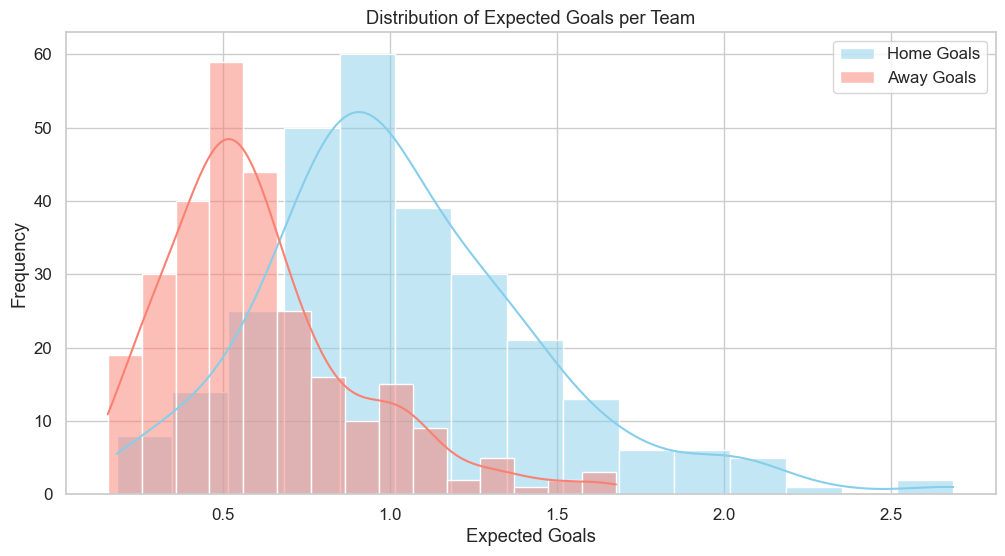

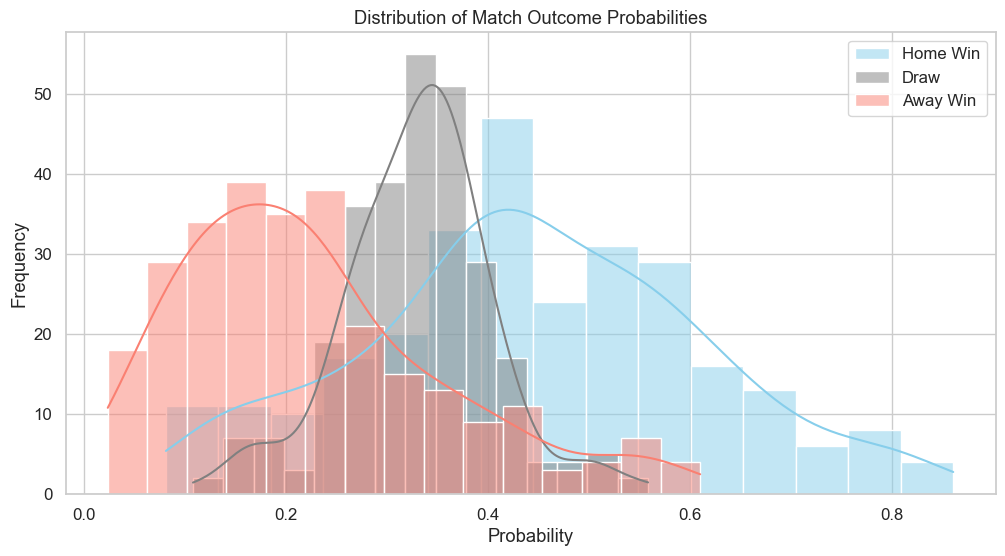

NameError: name 'season_table' is not defined

<Figure size 1200x600 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# ---------------- 1. Distribution of expected goals ----------------
plt.figure()
sns.histplot(sim_results['exp_home_goals'], color='skyblue', label='Home Goals', kde=True, bins=15)
sns.histplot(sim_results['exp_away_goals'], color='salmon', label='Away Goals', kde=True, bins=15)
plt.title("Distribution of Expected Goals per Team")
plt.xlabel("Expected Goals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# ---------------- 2. Match outcome probabilities ----------------
plt.figure()
sns.histplot(sim_results['prob_home_win'], color='skyblue', label='Home Win', kde=True, bins=15)
sns.histplot(sim_results['prob_draw'], color='gray', label='Draw', kde=True, bins=15)
sns.histplot(sim_results['prob_away_win'], color='salmon', label='Away Win', kde=True, bins=15)
plt.title("Distribution of Match Outcome Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# ---------------- 4. Goal difference vs points ----------------
plt.figure()
sns.scatterplot(x='goal_diff', y='points', data=season_table, hue='team', palette='tab20', s=100)
plt.title("Goal Difference vs Points")
plt.xlabel("Goal Difference")
plt.ylabel("Points")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ---------------- 5. Wins, Draws, Losses stacked ----------------
plt.figure()
season_table_sorted = season_table.sort_values('points', ascending=False)
plt.bar(season_table_sorted['team'], season_table_sorted['wins'], label='Wins', color='skyblue')
plt.bar(season_table_sorted['team'], season_table_sorted['draws'], bottom=season_table_sorted['wins'], label='Draws', color='gray')
plt.bar(season_table_sorted['team'], season_table_sorted['losses'], bottom=season_table_sorted['wins']+season_table_sorted['draws'], label='Losses', color='salmon')
plt.xticks(rotation=45)
plt.title("Simulated Season: Wins, Draws, Losses per Team")
plt.ylabel("Expected Matches")
plt.legend()
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ---------------- Build team-vs-team matrix ----------------
teams = np.sort(sim_results['home_team_name'].unique())
team_idx = {team:i for i, team in enumerate(teams)}

# Initialize matrix
win_matrix = np.zeros((len(teams), len(teams)))

# Fill matrix with home win probabilities
for _, row in sim_results.iterrows():
    i = team_idx[row['home_team_name']]
    j = team_idx[row['away_team_name']]
    win_matrix[i,j] = row['prob_home_win']  # probability home team wins

# Optional: average home & away perspective
# e.g., overall probability home beats away from either venue
overall_matrix = win_matrix.copy()
# If you want to include away perspective:
for _, row in sim_results.iterrows():
    i = team_idx[row['home_team_name']]
    j = team_idx[row['away_team_name']]
    overall_matrix[j,i] = row['prob_away_win']  # away team win as home team perspective

# ---------------- Plot heatmap ----------------
plt.figure(figsize=(12,10))
sns.heatmap(overall_matrix, xticklabels=teams, yticklabels=teams, annot=True, fmt=".2f", cmap="RdYlGn_r")
plt.title("Predicted Team-vs-Team Win Probabilities (Model Forecast)")
plt.xlabel("Away Team")
plt.ylabel("Home Team")
plt.show()



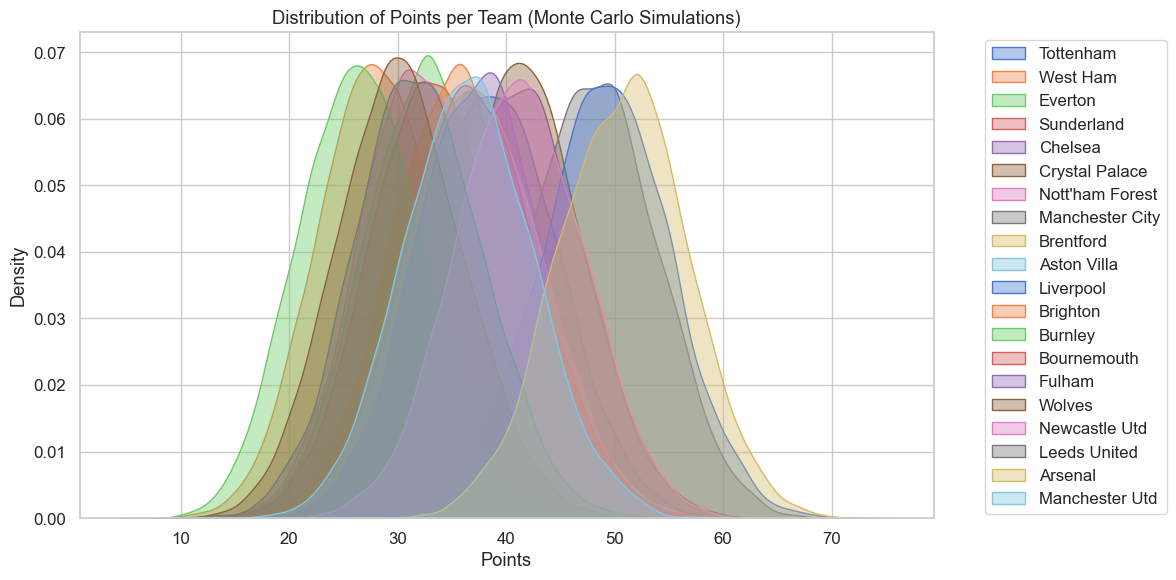

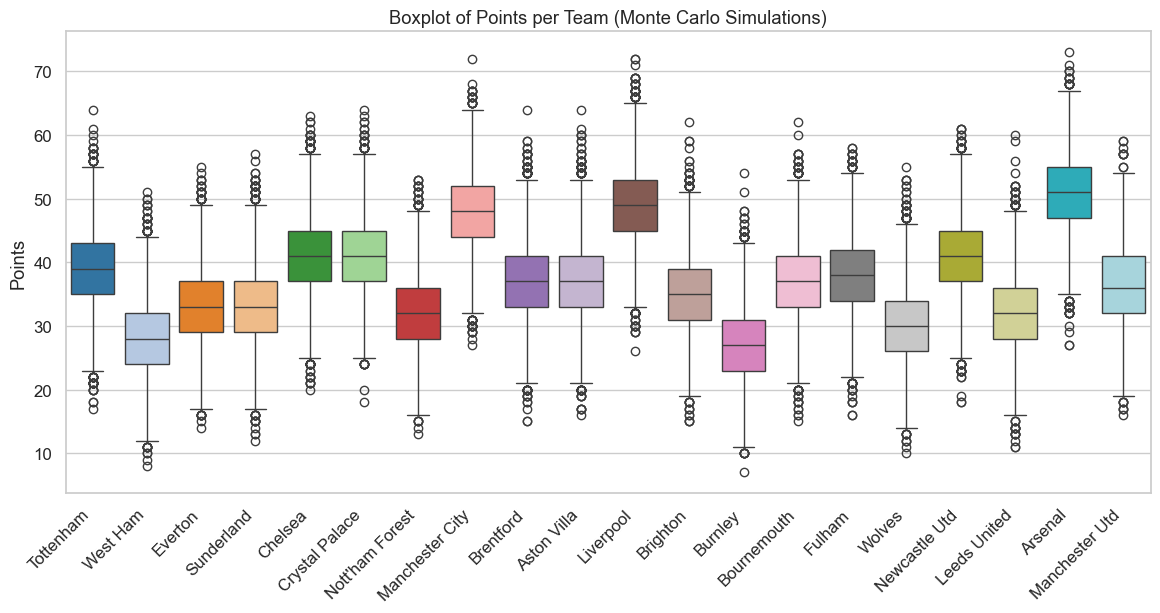

C:\Users\LEGION\AppData\Local\Temp\ipykernel_19000\2636013763.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




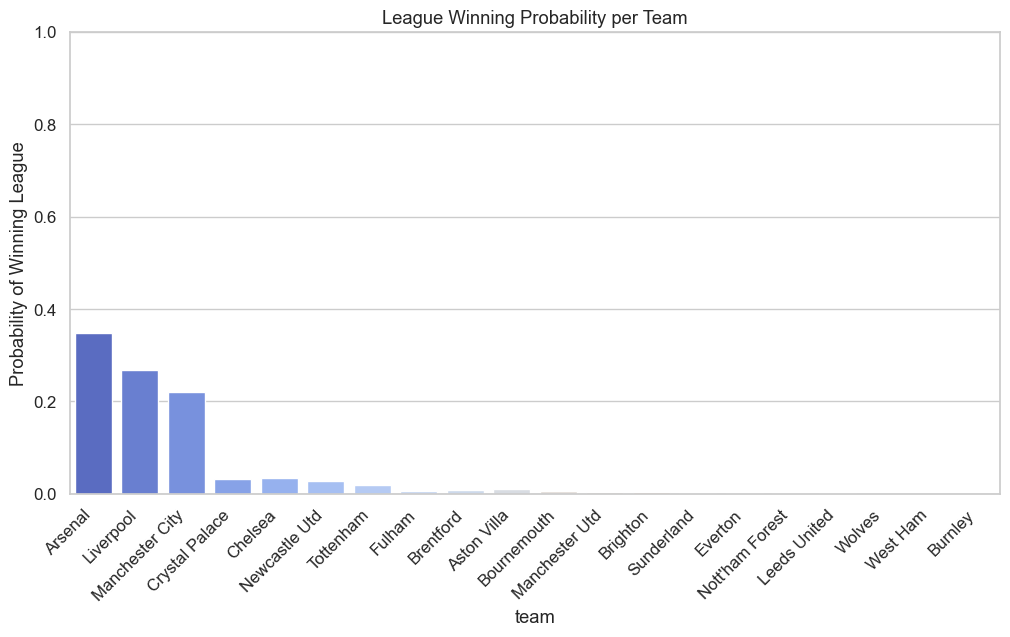

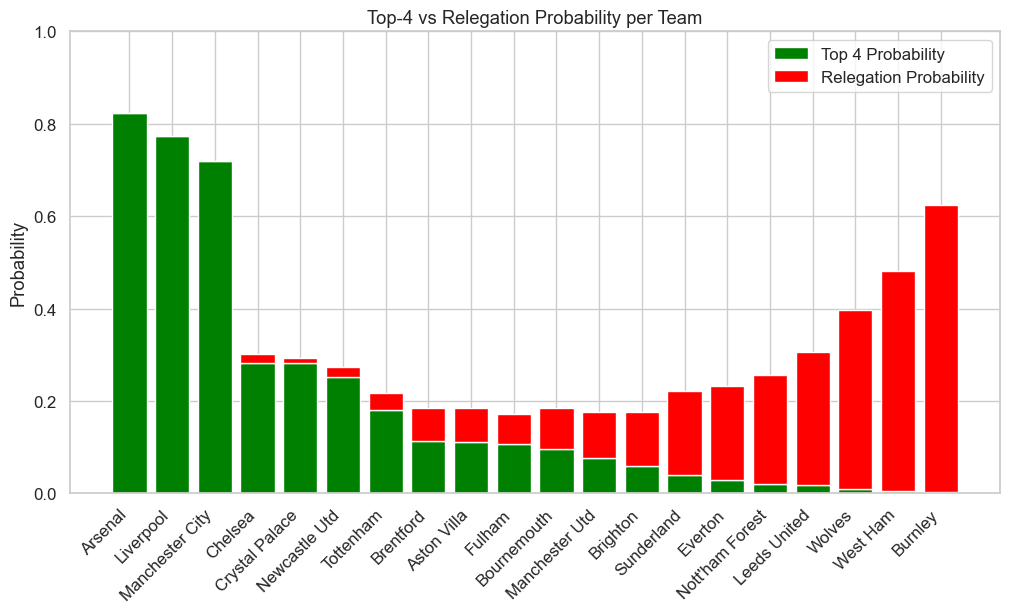

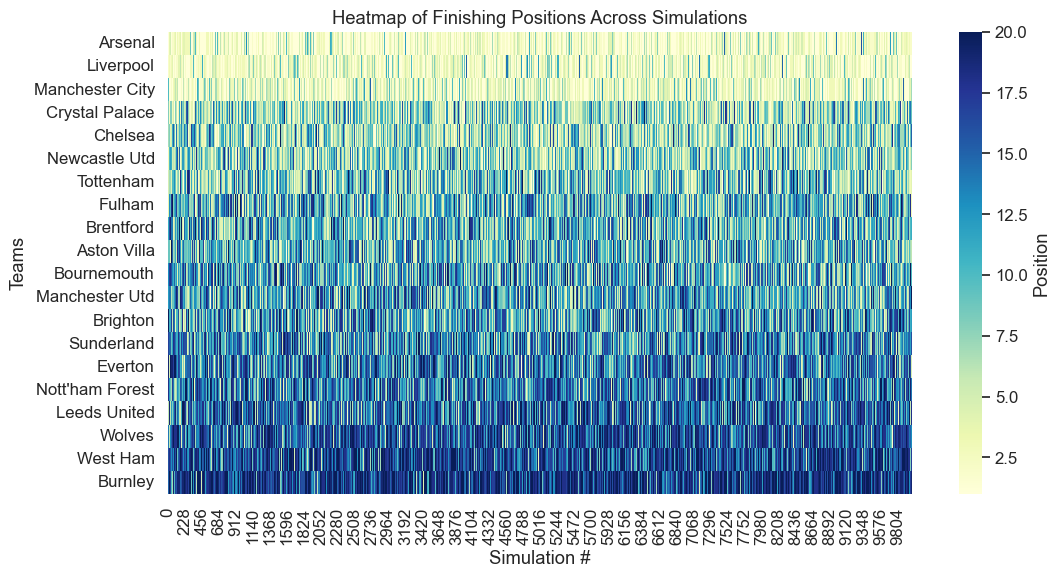

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted", font_scale=1.1)
teams = list(season_points_all.keys())

summary = pd.DataFrame({'team': teams})
summary['avg_points'] = summary['team'].apply(lambda t: np.mean(season_points_all[t]))
summary['std_points'] = summary['team'].apply(lambda t: np.std(season_points_all[t]))
summary['avg_position'] = summary['team'].apply(lambda t: np.mean(season_positions_all[t]))

summary['prob_win_league'] = summary['team'].apply(lambda t: np.mean(np.array(season_positions_all[t]) == 1))
summary['prob_top4'] = summary['team'].apply(lambda t: np.mean(np.array(season_positions_all[t]) <= 4))
summary['prob_relegation'] = summary['team'].apply(lambda t: np.mean(np.array(season_positions_all[t]) >= len(teams)-2))

summary = summary.sort_values('avg_position')
plt.figure(figsize=(12,6))
for t in teams:
    sns.kdeplot(season_points_all[t], label=t, fill=True, alpha=0.4)
plt.title("Distribution of Points per Team (Monte Carlo Simulations)")
plt.xlabel("Points")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.figure(figsize=(14,6))
points_df = pd.DataFrame({t: season_points_all[t] for t in teams})
sns.boxplot(data=points_df, palette="tab20")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Points")
plt.title("Boxplot of Points per Team (Monte Carlo Simulations)")
plt.show()
plt.figure(figsize=(12,6))
sns.barplot(x='team', y='prob_win_league', data=summary, palette="coolwarm")
plt.ylabel("Probability of Winning League")
plt.title("League Winning Probability per Team")
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)
plt.show()
plt.figure(figsize=(12,6))
summary_sorted = summary.copy()
summary_sorted = summary_sorted.sort_values('prob_top4', ascending=False)

plt.bar(summary_sorted['team'], summary_sorted['prob_top4'], label="Top 4 Probability", color='green')
plt.bar(summary_sorted['team'], summary_sorted['prob_relegation'], bottom=summary_sorted['prob_top4'], label="Relegation Probability", color='red')
plt.ylabel("Probability")
plt.title("Top-4 vs Relegation Probability per Team")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.ylim(0,1)
plt.show()
plt.figure(figsize=(12,6))
pos_df = pd.DataFrame({t: season_positions_all[t] for t in teams})
avg_pos = pos_df.mean().sort_values()
sns.heatmap(pos_df[avg_pos.index].T, cmap="YlGnBu", cbar_kws={'label': 'Position'})
plt.ylabel("Teams")
plt.xlabel("Simulation #")
plt.title("Heatmap of Finishing Positions Across Simulations")
plt.show()


In [6]:
import plotly.graph_objects as go
import plotly.express as px

# ---------------- CV Metrics ----------------
folds = list(range(1, CV_FOLDS+1))
rmse_vals = [m[0] for m in cv_metrics]
r2_vals = [m[1] for m in cv_metrics]
acc_vals = [m[2]*100 for m in cv_metrics]

fig_cv = go.Figure()
fig_cv.add_trace(go.Bar(x=folds, y=rmse_vals, name='RMSE', marker_color='blue'))
fig_cv.add_trace(go.Bar(x=folds, y=r2_vals, name='R²', marker_color='green'))
fig_cv.add_trace(go.Bar(x=folds, y=acc_vals, name='Match Accuracy (%)', marker_color='orange'))
fig_cv.update_layout(
    title="Cross-Validation Metrics",
    xaxis_title="Fold",
    yaxis_title="Value",
    barmode='group'
)
fig_cv.show()

# ---------------- Poisson Predictions vs Actual ----------------
# Take first 50 matches for clarity
n_display = min(50, len(oof_preds))
matches_idx = np.arange(n_display)
fig_poisson = go.Figure()
fig_poisson.add_trace(go.Scatter(x=matches_idx, y=y_train_home.iloc[:n_display], 
                                 mode='lines+markers', name='Home Goals Actual'))
fig_poisson.add_trace(go.Scatter(x=matches_idx, y=oof_preds[:n_display,0], 
                                 mode='lines+markers', name='Home Goals Predicted'))
fig_poisson.add_trace(go.Scatter(x=matches_idx, y=y_train_away.iloc[:n_display], 
                                 mode='lines+markers', name='Away Goals Actual'))
fig_poisson.add_trace(go.Scatter(x=matches_idx, y=oof_preds[:n_display,1], 
                                 mode='lines+markers', name='Away Goals Predicted'))
fig_poisson.update_layout(title="Poisson Predictions vs Actual Goals", xaxis_title="Match Index", yaxis_title="Goals")
fig_poisson.show()

# ---------------- Monte Carlo Season Simulation Charts ----------------
# Avg Points
fig_points = px.bar(summary.sort_values('avg_points'), x='team', y='avg_points', 
                    title="Average Points per Team", text='avg_points')
fig_points.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig_points.show()

# Probability of Winning League
fig_win = px.bar(summary.sort_values('prob_win_league', ascending=False), x='team', y='prob_win_league', 
                 title="Probability of Winning League", text='prob_win_league')
fig_win.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_win.show()

# Probability of Top 4
fig_top4 = px.bar(summary.sort_values('prob_top4', ascending=False), x='team', y='prob_top4', 
                  title="Probability of Finishing in Top 4", text='prob_top4')
fig_top4.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_top4.show()

# Probability of Relegation
fig_rel = px.bar(summary.sort_values('prob_relegation', ascending=False), x='team', y='prob_relegation', 
                 title="Probability of Relegation", text='prob_relegation')
fig_rel.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig_rel.show()

# Avg Position
fig_pos = px.bar(summary.sort_values('avg_position'), x='team', y='avg_position', 
                 title="Average League Position", text='avg_position')
fig_pos.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig_pos.show()
